## CECS 551: Advanced Artifical Intelligence
Assignment 7: CIFAR 100 Dataset

## Exploring the Dataset

We will unload the dataset found here: https://www.cs.utoronto.ca/~kriz/cifar.html



In [21]:
import tarfile

def untar(file):
    '''This function will open the tar file and extract its contents into a designated folder'''
    file = tarfile.open(file)
    file.extractall('./Cifar100')
    file.close


untar('./cifar-100-python.tar.gz')

In [22]:
def unpickle(file):
    '''This function will load our data from the file into a dictionary'''
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

training_data = unpickle('./Cifar100/cifar-100-python/train')
testing_data = unpickle('./Cifar100/cifar-100-python/test')
labels = unpickle('./Cifar100/cifar-100-python/meta')

In [23]:
#Exploring the Dataset
print(training_data[b'data'].shape)
print(testing_data[b'data'].shape)
print(len(training_data[b'filenames']))
print(len(training_data[b'fine_labels']))
print(len(training_data[b'coarse_labels']))

(50000, 3072)
(10000, 3072)
50000
50000
50000


In [24]:
print(training_data[b'filenames'][5])
print(training_data[b'fine_labels'][5])
print(labels[b'fine_label_names'][86])
print(type(training_data[b'fine_labels']))

b'phone_s_002161.png'
86
b'telephone'
<class 'list'>


In [25]:
import numpy as np
#first we must convert our files accordingly from bytes to string
filenames_training = [t.decode('utf8') for t in training_data[b'filenames']]
fine_labels_training = training_data[b'fine_labels']

filenames_testing = [t.decode('utf8') for t in testing_data[b'filenames']]
fine_labels_testing = testing_data[b'fine_labels']

fine_label_names = [t.decode('utf8') for t in labels[b'fine_label_names']]

#Convert our images into numpy arrays:
train_data = list()
test_data = list()

#Convert our data numpy arrays into the appropriate shape:
for im in training_data[b'data']:
    image = np.zeros((32, 32,3), dtype=np.uint8)
    #images are 3072 sized arrays that need to be reshaped into 32 x 32 with 3 color channels
    image[...,0] = np.reshape(im[:1024], (32,32)) #red channel
    image[...,1] = np.reshape(im[1024:2048], (32,32)) #green channel
    image[...,2] = np.reshape(im[2048:], (32,32)) #blue channel
    train_data.append(image) #add our reshaped image into our training dataset

for im in testing_data[b'data']:
    image = np.zeros((32, 32,3), dtype=np.uint8)
    #images are 3072 sized arrays that need to be reshaped into 32 x 32 with 3 color channels
    image[...,0] = np.reshape(im[:1024], (32,32)) #red channel
    image[...,1] = np.reshape(im[1024:2048], (32,32)) #green channel
    image[...,2] = np.reshape(im[2048:], (32,32)) #blue channel
    test_data.append(image) #add our reshaped image into our training dataset



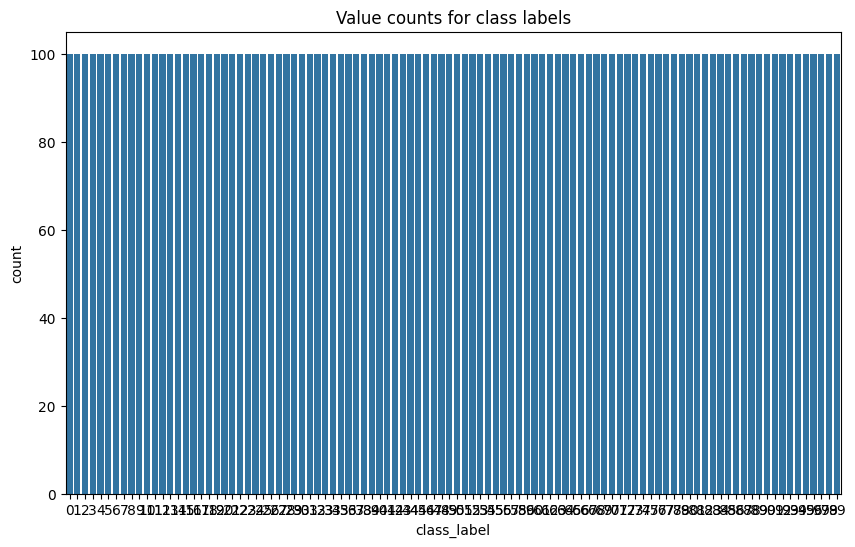

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
train_labels_df = pd.DataFrame(fine_labels_testing, columns=["class_label"]) 

plt.figure(figsize=(10,6))
plt.title('Value counts for class labels')
sns.countplot(x='class_label', data=train_labels_df)
plt.show()


The dataset is even so we can just use the train_test_split offered by keras, with a validation split of 20%

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
#Lets create our tuples
data = list(zip(train_data, fine_labels_training))

#shuffle our dataset
np.random.shuffle(data)

#desired validation ratio split
validation_ratio = 0.2

training_data, validation_data = train_test_split(data, test_size=validation_ratio)


In [28]:
print(len(training_data))
print(len(validation_data))
print(len(fine_label_names))

40000
10000
100


In [11]:
X_subtraining = [data[0] for data in training_data]
y_sublabels = [data[1] for data in training_data]
X_validation = [data[0] for data in validation_data]
y_vallabels = [data[1] for data in validation_data]

In [29]:
input_shape = X_subtraining[0].shape
print(input_shape)

(32, 32, 3)


In [30]:
X_subtraining = np.array(X_subtraining)
y_sublabels = np.array(y_sublabels)
X_validation = np.array(X_validation)
y_vallabels = np.array(y_vallabels)

print(y_vallabels.shape)

(10000,)


## Model Experimentation

Following we will experiment with a CNN built from scratch, multiple transfer learning model architectures, and various hyperparameters, and optimzers, and activation functions to find 
the top 3 models to train our entire dataset with.

In [14]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten

base_model = Sequential([
    
    Conv2D(filters=32, kernel_size =(3,3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Conv2D(filters= 64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters= 128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters= 256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters= 256, kernel_size=(3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(100, activation='softmax')
])
base_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

base_model.summary()


history_base = base_model.fit(X_subtraining, y_sublabels, epochs=30, validation_data=(X_validation, y_vallabels))

2023-11-03 19:36:15.967030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                        

In [17]:
best_model_accuracy = history_base.history['accuracy'][np.argmin(history_base.history['loss'])]
print(best_model_accuracy)
best_model_validation = history_base.history['val_accuracy'][np.argmin(history_base.history['loss'])]
print(best_model_validation)

0.934499979019165
0.32820001244544983


The base model built from scratch is currently suffering from overfitting. This means it does not generalize well. It may be more useful to then utilize transfer learning models to help with the generalization error.

In [31]:
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor = 0.20),
        layers.RandomTranslation(height_factor=0.15, width_factor=0.15),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.2)
    ], 
    name = "img_augmentation",
)

In [32]:
#Previously used sparse categorical loss function, but instead we will convert our labels into categorical matrix:
import keras
number_of_classes = 100
y_sub_labels = keras.utils.to_categorical(y_sublabels)
y_val_labels = keras.utils.to_categorical(y_vallabels)

## Implement Transfer learning 

In [33]:
from tensorflow import keras
from keras import layers

def build_VGG(num_classes, input_shape):
    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape, 
    input_tensor=x
    )
    #Freeze the pretrained weights
    conv_base.trainable = False
    #Build the Dense Layer
    x = layers.GlobalAveragePooling2D(name='avg_pool')
    x = layers.BatchNormalization()(x)
    drop_out_rate = 0.2
    x = layers.Dropout(drop_out_rate, name='drop_out_rate')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='pred')(x)

    #compile 
    model = tf.keras.Model(inputs, outputs, name="VGG16")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    return model
